In [1]:
# understand matrix structure of vectorizer
from sklearn.feature_extraction.text import CountVectorizer

words = ['one two three','one four five','two three six']
vectorizer = CountVectorizer()

vectorizer.fit(words)

print(vectorizer.vocabulary_)

{'one': 2, 'two': 5, 'three': 4, 'four': 1, 'five': 0, 'six': 3}


In [2]:
sample = vectorizer.transform([words[0]])

print(sample.toarray())

[[0 0 1 0 1 1]]


In [3]:
from os import listdir, getcwd, chdir
from os.path import isfile, join, dirname, realpath
import pandas as pd

import email
import email.parser
from email.parser import Parser

def get_cwd():
    try:
        chdir(dirname(realpath(__file__)))
    except:
        chdir('D:\Projects\MSDS-7333-QTW')

    active_dir = getcwd()
       
    return active_dir

def main():
    
    get_cwd()
    
    directories = [
            'easy_ham',
            'easy_ham_2',
            'hard_ham',
            'spam',
            'spam_2'
        ]
    
    res_frame = pd.DataFrame()

    # *dc - Added to keep a collection of email text
    emails = []

    emails_body = []
        
    for d in directories:
        mypath = getcwd() + '/SpamAssassinMessages/' + d + '/'
        onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    
        try:
            onlyfiles.remove('.DS_Store')
        except:
            pass
        
        for file in onlyfiles:
            with open(mypath + file, encoding='latin1') as f:
                lines = f.readlines()
                f.seek(0) # reset file pointer to beginning
                body = f.read()
                f.close()
            
            # with open(mypath + file, encoding='latin1') as f:
            #     body = f.read()
            #     f.close()
                
            msg = email.message_from_string(str(body))
            tmpStr = ''
            
            if msg.is_multipart():
                for payload in msg.get_payload():
                    #tmp.append(str(payload.get_payload()))
                    
                    tmpStr = ' '.join(str(payload.get_payload()))
                emails_body.append(tmpStr)
            else:
                emails_body.append(str(msg.get_payload()))
                
            in_reply_count = 0
            sub_line_all_caps = 0
            attachments = 0
            subject_line = []
            n_lines = 0
            blank_lines = []
            
            for line in lines:

                n_lines += 1
                if "Subject: Re: " in line:
                   in_reply_count += 1
                if "Subject: " in line:
                   s_line = line.strip().replace('Subject: ','')
                   s_line = ''.join(e for e in s_line if e.isalnum())
                   num_upper = sum(1 for c in s_line if c.isupper())
                   ttl_chars = len(s_line)
                   if num_upper == ttl_chars:
                       sub_line_all_caps += 1
                   subject_line.append(s_line)
                if "content-type: multipart" in line.lower():
                   attachments += 1
                if line == "\n":
                   blank_lines.append(n_lines)
        
            temp_frame = pd.DataFrame({
                        'directory':d,    
                        'filename':file,
                        'is_spam':['Y' if 'spam' in d else 'N'],
                        'in_reply': ['Y' if in_reply_count > 0 else 'N'], 
                        'subj_caps': ['Y' if sub_line_all_caps > 0 else 'N'], 
                        'attachments': ['Y' if attachments > 0 else 'N'],
                        ## *dc+3 
                        #'body_lines': n_lines - min(blank_lines)
                        'body_lines': [0 if len(blank_lines) == 0 else min(blank_lines)]
                        }, index=[0])
           
            res_frame = res_frame.append(temp_frame, ignore_index=True)

            ## *dc+2
            # append body of email to collection
            text = ' '.join(lines)
            emails.append(text)
            
    #res_frame.to_csv('output_file.csv', index=False)
    
    ## *dc - add emails
    return res_frame, emails, emails_body

## *dc - Working from a notebook instead of py file.
df, emails, emails_body = main()
# ########################################
# ##### Main Function
# ########################################    
# if __name__ == "__main__":
#     res_frame, emails = main()
#     pass   

In [4]:
print(len(df),len(emails),len(emails_body))

print(emails_body[3])

9353 9353 9353
Klez: The Virus That Won't Die
 
Already the most prolific virus ever, Klez continues to wreak havoc.

Andrew Brandt
>>From the September 2002 issue of PC World magazine
Posted Thursday, August 01, 2002


The Klez worm is approaching its seventh month of wriggling across 
the Web, making it one of the most persistent viruses ever. And 
experts warn that it may be a harbinger of new viruses that use a 
combination of pernicious approaches to go from PC to PC.

Antivirus software makers Symantec and McAfee both report more than 
2000 new infections daily, with no sign of letup at press time. The 
British security firm MessageLabs estimates that 1 in every 300 
e-mail messages holds a variation of the Klez virus, and says that 
Klez has already surpassed last summer's SirCam as the most prolific 
virus ever.

And some newer Klez variants aren't merely nuisances--they can carry 
other viruses in them that corrupt your data.

...

http://www.pcworld.com/news/article/0,aid,103

In [5]:
import nltk
import re 
import numpy as np

stop_words = nltk.corpus.stopwords.words('english')

def normalize_document(doc):
    # lowercase and remove special characters to form a normalized document
    doc = re.sub(r'[^a-zA-Z0-9\s]', ' ', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()

    # tokenize document
    tokens = nltk.word_tokenize(doc)
    
    # filter out stop words
    filtered_tokens = [token for token in tokens if token not in stop_words]

    # Remove numbers
    filtered_tokens = [token for token in filtered_tokens if not token.isdigit()]

    # Remove short tokens
    filtered_tokens = [token for token in filtered_tokens if len(token) > 2]

    # stem tokens - Skipping for now
    #filtered_tokens = [stemming.stem(token) for token in filtered_tokens]

    # re-create a normalized document
    doc = ' '.join(filtered_tokens)
    return doc

normalize_text = np.vectorize(normalize_document)
norm_text = normalize_text(emails)

print(type(norm_text),len(norm_text))

<class 'numpy.ndarray'> 9353


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf = TfidfVectorizer(ngram_range=(1,3), min_df=5, max_df=.8, stop_words=stop_words, norm='l2')
tf_matrix = tf.fit_transform(norm_text)

print(tf_matrix.shape)

(9353, 166742)


In [7]:
from sklearn.feature_extraction.text import CountVectorizer

cv = CountVectorizer(min_df=0, max_df=1., stop_words=stop_words)
cv_matrix = cv.fit_transform(norm_text)

print(cv_matrix.shape)

(9353, 180059)


In [8]:
print(df.columns)


Index(['directory', 'filename', 'is_spam', 'in_reply', 'subj_caps',
       'attachments', 'body_lines'],
      dtype='object')


In [25]:
df.sample(5)

,directory,filename,is_spam,in_reply,subj_caps,attachments,body_lines,kmeans_cluster
5082,easy_ham_2,00031.7caef7fe7af2114d0e4bf6aa0faf3a03,N,N,N,N,41,0
3155,easy_ham,0656.dd2af7ab5d99adf717056893adb12a20,N,Y,N,N,42,1
8020,spam_2,00066.af6bf70ea68b499585a72bdd7d6dd931,Y,N,N,N,24,12
7721,spam,0268.1aee52bc302bf1d5c2030229b5dbd63e,Y,N,N,N,47,12
3405,easy_ham,0906.2e604cc2a15e9f2a68c302861ac42ec5,N,Y,N,N,55,1


In [26]:
# replace all Y/N with 1/0

df = df.replace(['Y','N'],[1,0])

df.sample(5)

,directory,filename,is_spam,in_reply,subj_caps,attachments,body_lines,kmeans_cluster
7299,spam,00315.0ee82a2e087ffcf6efbd30b36499ead6,1,0,0,1,26,12
5129,easy_ham_2,00078.70afdc10249d68135ead7403a6257858,0,1,0,0,45,5
6958,spam,00005.57696a39d7d84318ce497886896bf90d,1,0,0,0,41,0
9255,spam_2,01304.114140cd4c51e9795559b974964aa043,1,0,0,1,39,3
8595,spam_2,00644.0f0a6c387d64887571426d7e28367947,1,0,0,0,39,7


In [27]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

NUM_CLUSTERS = 15
km = KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(tf_matrix)
km

df['kmeans_cluster'] = km.labels_

email_clusters = (df[['directory', 'kmeans_cluster']]
                  .sort_values(by=['kmeans_cluster'], 
                               ascending=False)
                  .groupby('kmeans_cluster').head(20))  # top 20 movies for each cluster
email_clusters = email_clusters.copy(deep=True)

feature_names = tf.get_feature_names()
topn_features = 50
ordered_centroids = km.cluster_centers_.argsort()[:, ::-1]

sample_silhouette_values = silhouette_samples(tf_matrix, km.labels_)

# get key features for each cluster
for cluster_num in range(NUM_CLUSTERS):

    cluster_silhouette_values = sample_silhouette_values[km.labels_ == cluster_num]

    key_features = [feature_names[index] 
                        for index in ordered_centroids[cluster_num, :topn_features]]
    print('CLUSTER #'+str(cluster_num+1), ":", cluster_silhouette_values.mean())
    print('Cluster Size', cluster_silhouette_values.shape[0])
    print('Key Features:', key_features)
    print('-'*80)

C:\Users\dancr\miniconda3\envs\NLP\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


CLUSTER #1 : 0.10440073277364481
Cluster Size 114
Key Features: ['social', 'iiu', 'linux', 'social linux', 'iiu taint org', 'iiu taint', 'ie', 'linux ie', 'social admin', 'social admin linux', 'lugh', 'tuatha', 'tuatha org', 'lugh tuatha', 'lugh tuatha org', 'social linux ie', 'taint org', 'taint', 'admin linux', 'ilug social', 'aug', 'social events social', 'events social', 'events social linux', 'users group social', 'group social', 'group social events', 'social events', 'iiu iiu', 'iiu iiu taint', 'mailto iiu', 'http iiu taint', 'http iiu', 'iiu admin', 'admin', 'events', 'jul', 'list', 'irish', 'admin taint org', 'admin taint', 'iiu admin taint', 'ilug', 'listinfo social', 'mailman listinfo social', 'iiu request', 'iiu request iiu', 'mailto iiu request', 'request iiu taint', 'request iiu']
--------------------------------------------------------------------------------
CLUSTER #2 : 0.17667751637647855
Cluster Size 1741
Key Features: ['fork', 'xent com', 'xent', 'fork admin xent', 

In [28]:
## Output a quick pivot table to see distribution of clusters vs spam/ham

df.pivot_table(index='kmeans_cluster', columns='is_spam', values='directory', aggfunc='count')

is_spam,0,1
kmeans_cluster,,
0,68.0,46.0
1,1691.0,50.0
2,654.0,NaN
3,59.0,424.0
4,307.0,15.0
5,651.0,74.0
6,131.0,NaN
7,257.0,461.0
8,203.0,NaN


In [12]:
df['directory'].value_counts()

easy_ham      5052
easy_ham_2    1401
spam_2        1398
spam          1001
hard_ham       501
Name: directory, dtype: int64

In [13]:
df.pivot_table(index='kmeans_cluster', columns='directory', values='filename', aggfunc='count')


directory,easy_ham,easy_ham_2,hard_ham,spam,spam_2
kmeans_cluster,,,,,
0,9.0,56.0,3.0,41.0,5.0
1,1314.0,377.0,NaN,NaN,50.0
2,502.0,148.0,4.0,NaN,NaN
3,NaN,NaN,59.0,168.0,256.0
4,260.0,45.0,2.0,10.0,5.0
5,195.0,456.0,NaN,62.0,12.0
6,109.0,20.0,2.0,NaN,NaN
7,4.0,NaN,253.0,172.0,289.0
8,160.0,43.0,NaN,NaN,NaN


In [ ]:
# # KMeans(n_clusters=NUM_CLUSTERS, max_iter=10000, n_init=50, random_state=42).fit(tf_matrix)
# scores = []

# for k in range(1, 20):
#     kmeans = KMeans(init="random", n_clusters=k, n_init=10, max_iter=300, random_state=42)
#     kmeans.fit(tf_matrix)
#     scores.append(kmeans.inertia_)

In [ ]:
# import matplotlib.pyplot as plt


# plt.style.use("fivethirtyeight")
# plt.figure(figsize=(12,6))
# plt.plot(range(1, 20), scores)
# plt.xticks(range(1, 20))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()

In [29]:
df['kmeans_cluster'] = df['kmeans_cluster'].astype(object)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9353 entries, 0 to 9352
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   directory       9353 non-null   object
 1   filename        9353 non-null   object
 2   is_spam         9353 non-null   int64 
 3   in_reply        9353 non-null   int64 
 4   subj_caps       9353 non-null   int64 
 5   attachments     9353 non-null   int64 
 6   body_lines      9353 non-null   int64 
 7   kmeans_cluster  9353 non-null   object
dtypes: int64(5), object(3)
memory usage: 584.7+ KB


# Prediction Without K-Means Feature

In [30]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import ShuffleSplit
from sklearn import metrics as mt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from matplotlib import pyplot
from sklearn.compose import ColumnTransformer
from sklearn.calibration import CalibratedClassifierCV
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_selector as selector
from sklearn.preprocessing import RobustScaler
# Imbalanced Data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imbpipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

# Pre-Processing
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score


categorical_features = ['in_reply','subj_caps','attachments']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [31]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000, n_jobs=-1)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = [{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'classifier__penalty': ['l1'],
               'classifier__solver': ['saga']},
              {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'classifier__penalty': ['l2'],
               'classifier__solver': ['lbfgs']}
             ]
              
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.7708778934447174
Test score: 0.7732259465612268


In [32]:
print(grid_search.best_params_)

{'classifier__C': 0.1, 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}


# Prediction Using K-Means as a Feature

In [33]:
categorical_features = ['in_reply','subj_caps','attachments','kmeans_cluster']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median")),
    ('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['classifier', LogisticRegression(random_state=11,
                                                                  max_iter=1000, n_jobs=-1)]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

param_grid = [{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'classifier__penalty': ['l1'],
               'classifier__solver': ['saga']},
              {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
               'classifier__penalty': ['l2'],
               'classifier__solver': ['lbfgs']}
             ]
              
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.9465508745648346
Test score: 0.9453023903666428


In [34]:
print(grid_search.best_params_)

{'classifier__C': 1000, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}


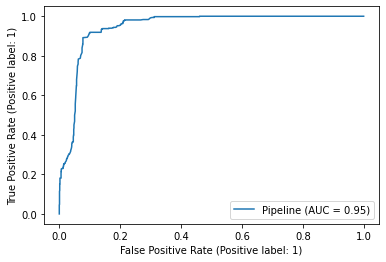

In [35]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)

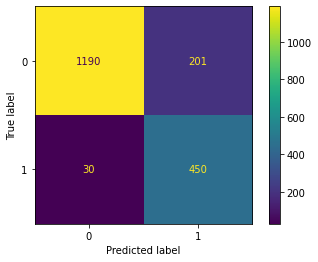

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(grid_search.best_estimator_, X_test, y_test)

# Accuracy, Recall, Precision Score
I think we need to consider using precision as our metric. We don't want to flag something as spam, when it should not be. The cost of a false positive in this case is high. I get upset when an important email goes to spam!

Contrast that with our previous case study where we used recall as our metric, since there was a high cost associated with false negatives. A false negative in that case is not telling a patient there is risk for heart disease, etc, when there actually really is.

Below our precision is on the low side.

In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

y_pred = grid_search.best_estimator_.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.8765366114377339
0.9375
0.6912442396313364


# Naive Bayes Classifer

In [39]:
from sklearn.naive_bayes import MultinomialNB

pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['classifier', MultinomialNB()]])


pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.8792089791555318
0.9375
0.6965944272445821


# Test without upsampling with smote

Significant difference!

In [40]:
clf = MultinomialNB()

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

print(accuracy_score(y_test, y_pred))
print(recall_score(y_test, y_pred))
print(precision_score(y_test, y_pred))

0.6718332442544094
0.60625
0.4064245810055866


## Below we try NB in grid search and alpha, no signficant difference compared to NB above with SMOTE.

In [50]:
categorical_features = ['in_reply','subj_caps','attachments','kmeans_cluster']
numeric_features = ['body_lines']

X = df[categorical_features + numeric_features]
y = df['is_spam']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="median"))]) #,
    #('scaler', RobustScaler(with_centering=False))])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.nan, strategy="most_frequent")),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


pipeline = imbpipeline(steps = [['preprocessor', preprocessor],
                                ['smote', SMOTE(random_state=11)],
                                ['classifier', MultinomialNB()]])

stratified_kfold = StratifiedKFold(n_splits=3,
                                       shuffle=True,
                                       random_state=11)

# param_grid = [{'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#                'classifier__penalty': ['l1'],
#                'classifier__solver': ['saga']},
#               {'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
#                'classifier__penalty': ['l2'],
#                'classifier__solver': ['lbfgs']}
#              ]

param_grid = [{'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1]}]
              
grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='precision',
                           cv=stratified_kfold,
                           n_jobs=-1)

grid_search.fit(X_train, y_train)
cv_score = grid_search.best_score_
test_score = grid_search.score(X_test, y_test)
print(f'Cross-validation score: {cv_score}\nTest score: {test_score}')

Cross-validation score: 0.6887964097509508
Test score: 0.6967340590979783


In [51]:
print(grid_search.best_params_)

{'classifier__alpha': 0.0001}
